# Movie recommendation using SVD

Following was one of Scalable Data Mining Assignments.

1. Load the MovieLens data and Convert the data into a matrix (for now, let it be dense)
2. (Optional: if the data is too big to handle, choose a subset of the ratings)
3. Leave out some non zero entries as a test set
4. Perform normalization 
5. Perform SVD
6. Compute the low rank ratings matrix according to the basic latent factor model
7. Test performance against the test data that is left out

First, download the data from: https://grouplens.org/datasets/movielens/

### 1. Load the dataset and convert the data into a matrix

Load the ratings.csv file and convert the data into a matrix R. Depending on how you load it, your movies may be rows or columns (and users vice versa). Mention that in the comment. 

In [ ]:
"""
import requests
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
content = requests.get(url)

# unzip the content
from io import BytesIO
from zipfile import ZipFile
f = ZipFile(BytesIO(content.content))
print(f.namelist())
f.extractall('./data')
"""

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import svds, eigs
import matplotlib.pyplot as plt

### Read Movies names

In [2]:
movies = pd.read_csv('./data/ml-1m/movies.dat', sep='::', header=None, usecols=[0,1,2], 
                 names = ['movieID', 'movie_name', 'Genres', 'timestamp'],engine='python', error_bad_lines=False)
# movies.to_csv('List of Movies.csv')

In [3]:
movies['Genre_List'] = [movies['Genres'][i].split('|') for i in range(len(movies))]

In [4]:
movies.head(5)

,movieID,movie_name,Genres,Genre_List
0,1,Toy Story (1995),Animation|Children's|Comedy,"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),Adventure|Children's|Fantasy,"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama,"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


#### Getting number of unique genres

In [5]:
genres = np.unique([movies['Genre_List'][i][j] for i in range(len(movies)) for j in range(len(movies['Genre_List'][i]))])

In [6]:
print(' No of movies:  ', len(movies), '\n',
      'List of', len(genres), 'genres:', ', '.join(genres))

 No of movies:   3883 
 List of 18 genres: Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western


### Reading Rating Data

In [7]:
df = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', header=None, usecols=[0,1,2], 
                 names = ['userID', 'movieID', 'rating'], engine='python', error_bad_lines=False)
# df.to_csv('Base Data.csv')

In [8]:
p=len(df['userID'].unique());q=len(df['movieID'].unique());r=len(movies);s=len(df);t=df['rating'].mean();u=df['rating'].std()
print(f'{p} unique users have rated {q} movies out of {r} and gave {s} ratings with an average of {t:.2f} and SD of {u:.2f}')

6040 unique users have rated 3706 movies out of 3883 and gave 1000209 ratings with an average of 3.58 and SD of 1.12


### Converting dataframe into sparse matrix for running SVD
**For my matrix, movies are columns and users are rows**

In [9]:
row = df.userID
col = df.movieID
data = df.rating
A = sparse.coo_matrix((data, (row, col)), dtype=float)

In [10]:
# np.savetxt("sparse A.csv", A.toarray(), delimiter=",")
row.shape, col.shape, data.shape, A.shape, type(A)

((1000209,), (1000209,), (1000209,), (6041, 3953), scipy.sparse.coo.coo_matrix)

### There are gaps in the movie id-s - 3953 vs. 3706 unique movie id-s. The gaps must be removed. Also, since the indexing starts from 0, one extra and row and column has been added.

### Mapping unique movie id-s to a running serial number

In [11]:
keyset = sorted(df['movieID'].unique())
valset = np.arange(len(df['movieID'].unique()))
movie_mapping = dict(zip(keyset,valset))

In [12]:
max(keyset), min(keyset), max(valset), min(valset)

(3952, 1, 3705, 0)

### Mapping unique user id-s to a running serial number

In [13]:
keyset = sorted(df['userID'].unique())
valset = np.arange(len(df['userID'].unique()))
user_mapping = dict(zip(keyset,valset))

In [14]:
max(keyset), min(keyset), max(valset), min(valset)

(6040, 1, 6039, 0)

### Mapping movie id-s to movie names

In [15]:
keyset = movies['movieID']
valset = movies['movie_name']
movie_name_mapping = dict(zip(keyset,valset))

### Mapping movie id-s to movie genres

In [16]:
keyset = movies['movieID']
valset = movies['Genres']
movie_genre_mapping = dict(zip(keyset,valset))

### Now we have to re-write the raw data in terms of the user and movie mapping above and then update the dataframe

In [17]:
df['user_srl'] = df['userID'].replace(user_mapping, inplace=False)

In [18]:
df['movie_srl'] = df['movieID'].replace(movie_mapping, inplace=False)

In [19]:
df['movie'] = df['movieID'].replace(movie_name_mapping, inplace=False)

In [20]:
df['Genre'] = df['movieID'].replace(movie_genre_mapping, inplace=False)

In [21]:
df.head()

,userID,movieID,rating,user_srl,movie_srl,movie,Genre
0,1,1193,5,0,1104,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,0,639,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,0,853,My Fair Lady (1964),Musical|Romance
3,1,3408,4,0,3177,Erin Brockovich (2000),Drama
4,1,2355,5,0,2162,"Bug's Life, A (1998)",Animation|Children's|Comedy


### Recreate the user-item matrix with contiguous id-s mapped from original user and movie id. 
**For my matrix, movies are columns and users are rows**

In [22]:
row = df.user_srl
col = df.movie_srl
data = df.rating
R = sparse.coo_matrix((data, (row, col)), dtype=float)

In [23]:
# np.savetxt("sparse A.csv", A.toarray(), delimiter=",")
row.shape, col.shape, data.shape, R.shape, type(R)

((1000209,), (1000209,), (1000209,), (6040, 3706), scipy.sparse.coo.coo_matrix)

### Run SVD on modified sparse rating matrix R, and reconstruct R_dash as an estimate of R

In [24]:
# Reconstruct SVD
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
from scipy.linalg import svd

U, s, VT = svd(R.toarray())
# create m x n Sigma matrix
Sigma = zeros((R.shape[0], R.shape[1]))
# populate Sigma with n x n diagonal matrix
Sigma[:R.shape[1], :R.shape[1]] = diag(s)
# reconstruct matrix
R_dash = U.dot(Sigma.dot(VT))

### The User and Movie Shapes

In [51]:
VT.shape, U.shape, s.shape
# vt.T[0].sum(), u[0].sum()

((3706, 3706), (6040, 6040), (3706,))

### 2. Optional: Reduce the size of the matrix

If you failed trying to run SVD with your matrix due to computational resources, reduce the size of the matrix and call the new matrix R. If you did not need to reduce the size of R, then simply set skip this step.

### Ran it on 1 million rating dataset. No problem.

### 3. Set your test set apart

Randomly choose about 2000 non-zero entries in R (2000 known ratings given by users to certain items) and create the test matrix B. Define A to be the rest of the non-zero entries. Essentially, A + B should be same as R. After the next few lines of code, you should have two matrices A and B. 

Note: A and B should have no common non-zero entry. The task here is to predict the zero (unknown) entries in A and test them against the available non-zero (known) entries in B.

### Test data carved out of full dataset

In [25]:
test = df.sample(n=2000, random_state=99)
row_te = test.user_srl
col_te = test.movie_srl
data_te = test.rating

In [26]:
p=len(test['user_srl'].unique());q=len(test['movie_srl'].unique());r=len(movies);s=len(test);t=test['rating'].mean();
u=test['rating'].std()
print(f'In the test dataset {p} unique users rated {q} movies out of total {r} and gave {s} ratings with an average of \
{t:.2f} and SD of {u:.2f}')

In the test dataset 1422 unique users rated 1135 movies out of total 3883 and gave 2000 ratings with an average of 3.57 and SD of 1.10


In [27]:
test.head()

,userID,movieID,rating,user_srl,movie_srl,movie,Genre
746925,4457,3203,4,4456,2983,Dead Calm (1989),Thriller
826104,4960,3543,4,4959,3309,Diner (1982),Comedy|Drama
618657,3749,852,2,3748,799,Tin Cup (1996),Comedy|Romance
96591,648,2858,5,647,2651,American Beauty (1999),Comedy|Drama
352290,2063,2763,3,2062,2558,"Thomas Crown Affair, The (1999)",Action|Thriller


### Creating the balance as training dataset

In [28]:
train = df.loc[~df.index.isin(test.index), :]
row_tr = train.user_srl
col_tr = train.movie_srl
data_tr = train.rating

In [29]:
p=len(train['user_srl'].unique());q=len(train['movie_srl'].unique());r=len(movies);s=len(train);t=train['rating'].mean();
u=train['rating'].std()
print(f'In the train dataset {p} unique users rated {q} movies out of total {r} and gave {s} ratings with an average of \
{t:.2f} and SD of {u:.2f}')

In the train dataset 6040 unique users rated 3706 movies out of total 3883 and gave 998209 ratings with an average of 3.58 and SD of 1.12


In [30]:
train.head()

,userID,movieID,rating,user_srl,movie_srl,movie,Genre
0,1,1193,5,0,1104,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,0,639,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,0,853,My Fair Lady (1964),Musical|Romance
3,1,3408,4,0,3177,Erin Brockovich (2000),Drama
4,1,2355,5,0,2162,"Bug's Life, A (1998)",Animation|Children's|Comedy


### The train and test data have very similar distribution judged from their mean and SD vs. the total data

**Create train dataset for SVD**

In [31]:
B = sparse.coo_matrix((data_te, (row_te, col_te)), dtype=float)
A = sparse.coo_matrix((data_tr, (row_tr, col_tr)), dtype=float)

In [32]:
# index
A.shape, (A>0).sum(), A.sum(), A.mean(), A.sum()/(A>0).sum()
# B.shape, (B>0).sum(), B.sum(), B.mean(), B.sum()/(B>0).sum()

((6040, 3706), 998209, 3575167.0, 0.15971804269432424, 3.581581612668289)

### Run full SVD on sparse training matrix A amd reconstruct A_dash

In [33]:
# Reconstruct SVD
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
from scipy.linalg import svd
# Singular-value decomposition
U, s, VT = svd(A.toarray())
# create m x n Sigma matrix
Sigma = zeros((A.shape[0], A.shape[1]))
# populate Sigma with n x n diagonal matrix
Sigma[:A.shape[1], :A.shape[1]] = diag(s)
# reconstruct matrix
A_dash = U.dot(Sigma.dot(VT))

### The User and Movie Shapes

In [53]:
VT.shape, U.shape, s.shape
# vt.T[0].sum(), u[0].sum()

((3706, 3706), (6040, 6040), (3706,))

### Compute Error vs. 2000 held out ratings in test dataframe based on un-normalized training data using A_dash

In [34]:
error = [A_dash[test.iloc[i]['user_srl'], test.iloc[i]['movie_srl']] - test.iloc[i]['rating'] for i in range(len(test))]
rmse = np.sqrt(np.mean(np.square(error)))
print('Root mean square error of test data using un-normalized raw training data:', rmse)

Root mean square error of test data using un-normalized raw training data: 3.7393849761692106


### Very high RMSE with reconstructed A

### 4. Normalize and center 

Please note that in A, B or R, the zero entries do not mean the corresponding ratings are zero. They are just unknown. Hence, you need to impute the missing (zero now) entries of A by the average of the known entries (row or column depending on how you have loaded your matrix) for each item. Call this matrix A1.

Then, subtract the average rating given by each user from the corresponding row (or column). Call this matrix A2.

### Compute Average Movie Ratings of all users who have rated the movie i.e. column averages

In [35]:
A1 = A.toarray()
movie_avg = [A1[:,i].sum()/(A1[:,i]>0).sum() for i in range(A.shape[1])]

### Insert average rating of a movie in the blanks of the corresponding column

In [36]:
for i in range(A.shape[1]):
    A1[A1[:,i]==0, i] = movie_avg[i]

### Compute Average Rating of each user for the movies he/she has rated i.e. row averages

In [37]:
user_avg = A1.mean(axis=1).reshape(-1,1)
user_avg, user_avg.shape

(array([[3.24259423],
        [3.23698306],
        [3.24047854],
        ...,
        [3.23779661],
        [3.23600795],
        [3.21255326]]), (6040, 1))

### Normalized Rating of each user for each movie he/she has rated or imputed with movie average - dense matrix

In [38]:
A2 = A1 - user_avg

In [39]:
# A1 = 
# A2 = 

### 5. Compute SVD 

Compute SVD of the matrix A2.

In [40]:
# Use your choice of variables for U, Sigma and V_transpose
# Compute SVD of A2

### Run full SVD on filled in training matrix A2 and reconstruct A2_dash

In [41]:
# Reconstruct SVD
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
from scipy.linalg import svd
# Singular-value decomposition
U, s, VT = svd(A2)
# create m x n Sigma matrix
Sigma = zeros((A2.shape[0], A2.shape[1]))
# populate Sigma with n x n diagonal matrix
Sigma[:A2.shape[1], :A2.shape[1]] = diag(s)
# reconstruct matrix
A2_dash = U.dot(Sigma.dot(VT))

### The User and Movie Shapes

In [54]:
VT.shape, U.shape, s.shape
# vt.T[0].sum(), u[0].sum()

((3706, 3706), (6040, 6040), (3706,))

### Reconstruct A_dash from SVD components of A2 and evaluate with test data. Here we will have to add back the user average rating that was subtracted to get A2.

### Compute Error compared 2000 rating that were held out in test dataframe

In [42]:
error_A2 = [A2_dash[test.iloc[i]['user_srl'], test.iloc[i]['movie_srl']] + 
            user_avg[test.iloc[i]['user_srl']] -
            test.iloc[i]['rating'] for i in range(len(test))]
rmse_A2 = np.sqrt(np.mean(np.square(error_A2)))
print(f'Root mean square error of test data using full normalized A2: {rmse_A2:.6f}')

Root mean square error of test data using full normalized A2: 0.977687


# MUCH BETTER!

**Down to under 1 scale point**

### 6. Compute the low rank approximation 

Compute the low rank approximation of A2. The choice of k is up to you, but we would encourage you to try out a few different k and see which works better. Mention your experience in the readme report.

### Run SVD on sparse training matrix A2, with different values of k to minimize recontruction error. We have 0.98 as baseline with full SVD reconstruction.
https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/

### Small function to compute reconstructed matrix for different values of k

In [43]:
def reconfromsvd(a, k):
    u, s, vt = svds(a,k)
    # create kxk Sigma matrix
    Sigma = np.zeros((k,k))
    # populate Sigma with k diagonal elements
    np.fill_diagonal(Sigma, s)
    # reconstruct matrix
    a_dash = u.dot(Sigma.dot(vt))
    
    return a_dash

### Plot for optimum number of dimensions K

In [45]:
plot_val = []
for K in np.arange(10, 310, 5):
    A2_dash = reconfromsvd(A2,K)
    error = [A2_dash[test.iloc[i]['user_srl'], test.iloc[i]['movie_srl']] +
             user_avg[test.iloc[i]['user_srl']] -
             test.iloc[i]['rating'] for i in range(len(test))]
    rmse = np.sqrt(np.mean(np.square(error)))
    val = [K,rmse]
    plot_val.append(val)

In [46]:
x = [plot_val[i][0] for i in range(len(plot_val))]
y = [plot_val[i][1] for i in range(len(plot_val))]

In [47]:
plot_val

[[10, 0.9131434967506512],
 [15, 0.9061812540318722],
 [20, 0.9027367006179087],
 [25, 0.9006506197112903],
 [30, 0.900342337193108],
 [35, 0.8988774616005114],
 [40, 0.8983756179904772],
 [45, 0.9000259099159102],
 [50, 0.8985059454472567],
 [55, 0.8987354489946084],
 [60, 0.900013818898485],
 [65, 0.9029895245974098],
 [70, 0.9034808545984178],
 [75, 0.9031609411068028],
 [80, 0.9048887391530405],
 [85, 0.9054657057757517],
 [90, 0.9056111979313228],
 [95, 0.9068924913607322],
 [100, 0.905437895877992],
 [105, 0.9052984459393246],
 [110, 0.9058044672221505],
 [115, 0.9056841773471973],
 [120, 0.9078304727428763],
 [125, 0.909403026910552],
 [130, 0.9109732887836823],
 [135, 0.9115631037907335],
 [140, 0.912208656523862],
 [145, 0.912183674443807],
 [150, 0.9131249417824991],
 [155, 0.9138169417600777],
 [160, 0.915252375201121],
 [165, 0.9154565248334358],
 [170, 0.9175721956734322],
 [175, 0.91643343905622],
 [180, 0.9179117115459987],
 [185, 0.9176595523851356],
 [190, 0.9179225816

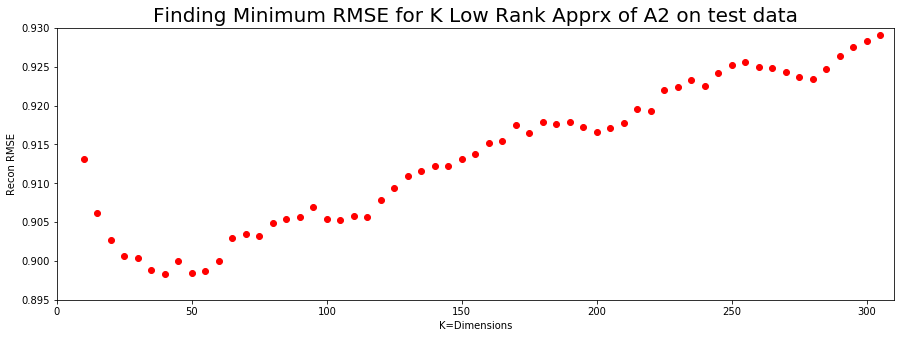

In [48]:
plt.figure(figsize=(15,5))
plt.plot(x, y, 'ro')
plt.axis([0, 310, 0.895, 0.93])
# plt.xaxis([np.arange(10, 210, 10)])
# plt.yaxis([0.89, 0.92])
plt.xlabel('K=Dimensions')
plt.ylabel('Recon RMSE')
plt.title('Finding Minimum RMSE for K Low Rank Apprx of A2 on test data', fontsize=20)
plt.show()

### RMSE corresponding to K=40 gives the lowest value

In [49]:
RMSE_Ak_min=plot_val[6][1];K_min=plot_val[6][0]
print(f'The lower Root mean square error, {RMSE_Ak_min:.6f} for test data comes for k = {K_min} using normalized A2')

The lower Root mean square error, 0.898376 for test data comes for k = 40 using normalized A2


#  k=40 minimizes SVD recon RMSE=0.8984 on normalized A2. Can be thought of as there exists 40 sub genres which are different combinations of 18 current ones that should provide coherent clustering of movies

### 7. Test the performance

Compute the root-mean-squared-error (RMSE) against the known ratings to test how the method performed, using A1 (which predicts ratings just by average known ratings) and Ak against B.

The RMSE is the square root of the average squared errors between the known ratings and the predicted ratings. For our set up, consider only the pairs of (user,item) pairs (i,j) for which B[i,j] > 0. Then compute the square root of the average squared difference between A2 and B (also Ak and B) only for this set of pairs (i,j). 

$$RMSE(A2, B) = \sqrt{\frac{\sum_{i,j: B_{ij} > 0}(A2_{ij} - B_{ij})^2}{\sum_{i,j: B_{ij} > 0} 1}}.$$

$$RMSE(Ak, B) = \sqrt{\frac{\sum_{i,j: B_{ij} > 0}(Ak_{ij} - B_{ij})^2}{\sum_{i,j: B_{ij} > 0} 1}}.$$

In [50]:
# Write your code here (several lines)
# At the end of the code, your must have two variables with the RMSEs (will not be 0.0), as given below
RMSE_A2 = rmse_A2
RMSE_Ak = RMSE_Ak_min
print("RMSE with A2 is %f." %RMSE_A2)
print("RMSE with Ak is %f." %RMSE_Ak)

RMSE with A2 is 0.977687.
RMSE with Ak is 0.898376.
